# Investigate Agenda Setting

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

# this might be less clean than running the script with %run -i 'preamble.py'
# but since the working directory is changed in that script, if we re-ran it, it would not be found anymore 
# because it is then located in experiments/preamble.py 
# => use import instead so it is run once and will not be run again
import preamble
from src.constants import PATH_ALL_SPEECHES, PATH_MIGRATION_SPEECHES_EMBEDDED, COLOR_MAPS

In [2]:
df_final = pd.read_parquet(PATH_ALL_SPEECHES)
final_topic_col = "migration_prob"
final_threshold = 0.25
embedding_model = 'google/embeddinggemma-300m'
party_column = "block" # "party"

colormap = COLOR_MAPS[party_column]

In [3]:
df_migration = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)

In [4]:
df_final.index

Index([     1,      3,      4,      5,      6,      7,      8,      9,     10,
           11,
       ...
       292033, 292034, 292035, 292036, 292037, 292043, 292046, 292048, 292051,
       292054],
      dtype='int64', length=236812)

In [5]:
# only the speeches that are classified as migration 
df_migration_speeches = df_final[df_final[final_topic_col] >= final_threshold]

# full debates where at least one speech is migration related
df_all_speeches_with_one_migration_in_agenda = df_final[df_final["agenda"].isin(df_migration_speeches["agenda"])]

In [6]:
def print_agendas(agenda_items, first_k=3):
    """
    For each agenda item of the first k in agenda_items:
    Print the debates of the agenda items, by printing
    Agenda title etc.
    [{x if classfied as migration}] {speechnumber}: {speaker} {party block} {migration score} \n speech
    """
    for agenda in agenda_items[:first_k]: 
        df_agenda = df_final[df_final["agenda"] == agenda]
        print(agenda)
        
        migration_contributions = df_agenda[df_agenda[final_topic_col] > final_threshold]

        print("Parties talking about migration:", ', '.join (f'{b} ({n})' for b, n in migration_contributions[party_column].value_counts().items()))
        for _, row in df_agenda.iterrows():
            migration_score = row[final_topic_col]
            marker_is_migration = "[x]" if migration_score > final_threshold else "[ ]"

            translatedText = row["translatedText"].replace("\n", "\n\t")
            print(f'{marker_is_migration} {row["speechnumber"]}: {row["speaker"]} ({row["party"]} - {row["block"]}) [{int(migration_score*100)}% migration]\n\t{translatedText}')

        print("="*50, "end of agenda item", "="*50)

In [7]:
def entropy(values): 
    # Compute the shannon entropy of the value series
    total = len(values)

    probs = np.array([n/total for _, n in values.value_counts().items()])
    log_probs = np.log2(probs)
    return - (probs * log_probs).sum()

def effective_number_of_parties(values): 
    # Compute the effective number of parties (https://en.wikipedia.org/wiki/Effective_number_of_parties)
    probs = np.array(values.value_counts(normalize=True))
    return 1 / (probs * probs).sum()

migration_speeches_grouped_by_agenda = df_migration_speeches.groupby("agenda").agg(
    party_entropy_migration = pd.NamedAgg(party_column, entropy), 
    n_parties_migration = pd.NamedAgg(party_column, lambda x: len(set(x))),
    parties_migration = pd.NamedAgg(party_column, set), 
    n_speeches_migration = pd.NamedAgg("translatedText", len),
    effective_n_parties_migration = pd.NamedAgg(party_column, effective_number_of_parties),
)
all_speeches_grouped_by_agenda = df_all_speeches_with_one_migration_in_agenda.groupby("agenda").agg(
    party_entropy = pd.NamedAgg(party_column, entropy), 
    n_parties = pd.NamedAgg(party_column, lambda x: len(set(x))),
    parties = pd.NamedAgg(party_column, set), 
    n_speeches = pd.NamedAgg("translatedText", len),
    avg_migration_score = pd.NamedAgg(final_topic_col, "mean"),
    effective_n_parties = pd.NamedAgg(party_column, effective_number_of_parties),
    date = pd.NamedAgg("date", "first"), # assume the date is the same for all agenda items, 
    year = pd.NamedAgg("year", "first") 
)

# dataframe created has per agenda item:
# 'party_entropy[_migration]': entropy of parties talking about this agenda item [about migration]
# 'n_parties[_migration]': number of parties ... 
# 'effective_n_parties[_migration]'
# 'parties[_migration]': list of parties ... 
# 'n_speeches[_migration]': number of speeches in this agenda item [about migration]
# 'avg_migration_score': average migration score of the speeches
# proportion_migration_speeches

migration_agendas = all_speeches_grouped_by_agenda.join(migration_speeches_grouped_by_agenda)
migration_agendas["proportion_migration_speeches"] = migration_agendas["n_speeches_migration"] / migration_agendas["n_speeches"]

In [8]:
len(migration_agendas[migration_agendas["n_speeches_migration"] == 0])

0

## Agendas with many migration speeches: 

In [9]:
min_avg_migration_score = migration_agendas["avg_migration_score"].mean() + migration_agendas["avg_migration_score"].std()
# use final threshold instead? 

agendas_many_migration_speeches = migration_agendas[migration_agendas["avg_migration_score"] > min_avg_migration_score]
print(len(agendas_many_migration_speeches),"agenda items with >", min_avg_migration_score, "avg. migration score")


for i, item in enumerate(agendas_many_migration_speeches.index.unique()):
    print(i, item)

177 agenda items with > 0.26751794411413404 avg. migration score
0 1. Opening of the sitting2018-10-03
1 10. EU policies and actions to protect children in the context of migration (debate)2016-10-26
2 10. Legal migration policy and law (debate)2021-11-23
3 10. Major interpellations (debate)2024-02-29
4 10. Provisional measures in the area of international protection for the benefit of Italy and Greece (debate)2015-09-08
5 10. Refugee emergency, external borders control and future of Schengen - Respect for the international principle of non-refoulement - Financing refugee facility for Turkey - Increased racist hatred and violence against refugees and migrants across Europe (debate)2016-02-02
6 10. Signing of acts adopted in accordance with the ordinary legislative procedure (Rule 79)2023-05-31
7 10. Verification of credentials2018-07-03
8 10.1. Refugees in Europe: CARE (C9-0057/2022)2022-03-24
9 10.4. EU Protection of children and young people fleeing the war against Ukraine (B9-0207/2

In [10]:
print_agendas(agendas_many_migration_speeches.index, 1)

1. Opening of the sitting2018-10-03
Parties talking about migration: social_democratic (1)
[x] 1: Cécile Kashetu Kyenge (PSE/S&D - social_democratic) [55% migration]
	Mr President, ladies and gentlemen, on 3 October 2013, 366 people lost their lives off the coast of Lampedusa, in an attempt to reach our coasts. The government of the time responded by launching the largest humanitarian mission in the Mediterranean, Mare Nostrum. My thoughts today go not only to the victims, but also to those who are committed, every day, to saving human lives, to the women and men of the Italian Coast Guard, to the mayors involved in reception and integration, to the NGOs, unfortunately increasingly criminalized for their humanitarian activity. I would like this date to be remembered as Remembrance Day to honor all the men, women and children who lost their lives because they were forced to leave their country.
================================================== end of agenda item =======================

=> the agenda is very much related to migration! but the speeches marked as non-migration are indeed also not clearly about migration (e.g. "Madam President, whether it was an official reprimand or not, Mr Vandendriessche has been told that he cannot use Nazi terminology in this chamber and that he was not allowed to do so. So I expect the Presidency of this House to take the necessary steps.": 0% migration); => we should not include these for our embedding analyses because they introduce noise.

## Do parties do agenda-setting?

only considering agenda items with > 5.459389843744717 speeches: 978 of 1054


<Axes: title={'center': 'How many parties (effectively) talk about migration per agenda item? [Frequency]'}, ylabel='Frequency'>

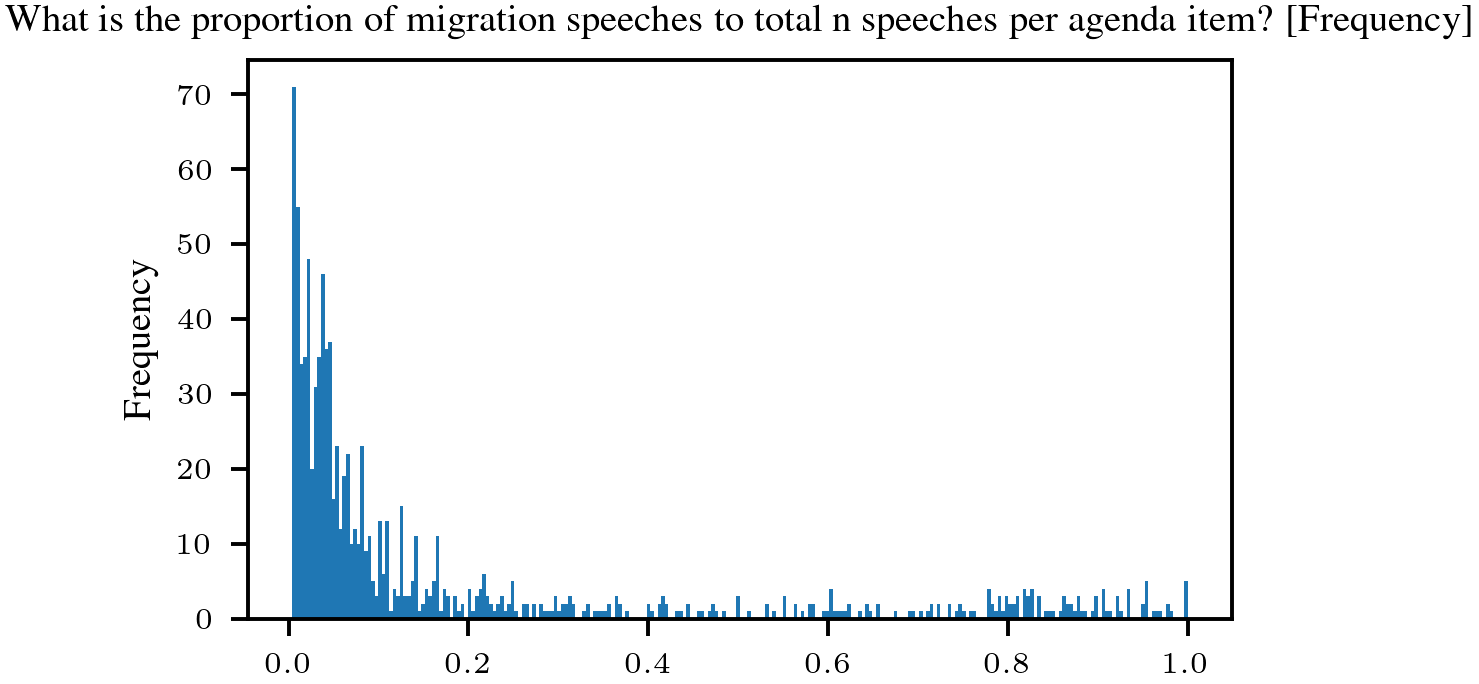

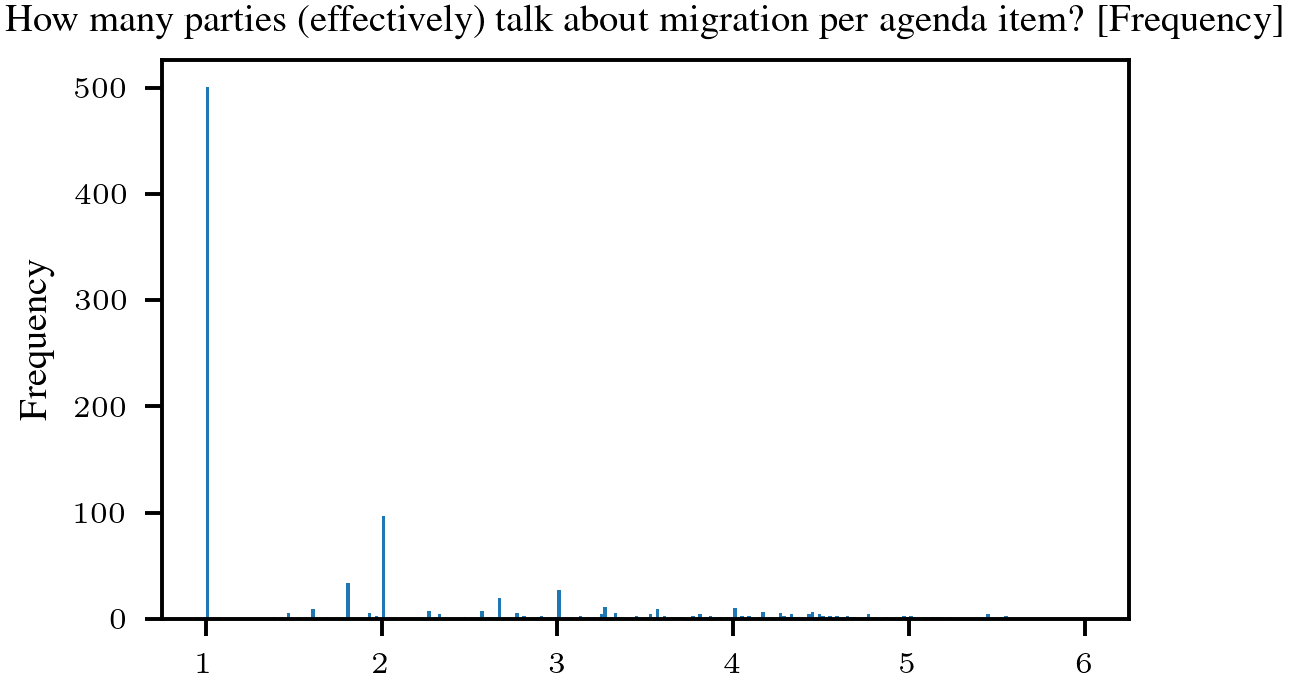

In [11]:
# ignore agenda items with only a few speeches
min_speeches_per_agenda = migration_agendas["n_speeches"].mean() - migration_agendas["n_speeches"].std()

migration_agendas_with_debates = migration_agendas[migration_agendas["n_speeches"] > min_speeches_per_agenda].sort_values("n_speeches")
print("only considering agenda items with >", min_speeches_per_agenda, "speeches:", len(migration_agendas_with_debates), "of", len(migration_agendas))

plt.figure()
migration_agendas_with_debates["proportion_migration_speeches"].plot.hist(bins=250, title="What is the proportion of migration speeches to total n speeches per agenda item? [Frequency]")
plt.figure()
migration_agendas_with_debates["effective_n_parties_migration"].plot.hist(bins=250, title="How many parties (effectively) talk about migration per agenda item? [Frequency]")

Other analyses: 
- agenda setting is not n_speeches_migration == 1 (what if two people from the same party keep setting the agenda) 
=> instead: look at those agenda items, where the party entropy is low => when it is 0: the party is the only party that talks about migration
- but: what if only conservative & right parties talk about migration? => TODO: capure this
- then: is there a yearly trend? => did agenda setting increase over time? did conservative parties start to also join agenda setting?

In [12]:
# Source - https://stackoverflow.com/a
# Posted by Padraic Cunningham, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-25, License - CC BY-SA 3.0

from collections import Counter
from itertools import combinations

def count_pairs(partent_list):
    d  = Counter()
    for sub in partent_list:
        if len(partent_list) > 1: 
            sub = list(sub)
            sub.sort()
            for comb in combinations(sub, 2):
                d[comb] += 1
    return d 

In [13]:
def investigate_agenda_setting(year=None, effective_n_parties_threshold=2): 
    # effective n parties migration <= 1? 
    # TODO prop effective n parties miration / n parties general should be low? 
    agendas_with_low_n_parties_migration = migration_agendas_with_debates[migration_agendas_with_debates["effective_n_parties_migration"] <= effective_n_parties_threshold]
    
    # only in that year
    if year is not None:
        agendas_with_low_n_parties_migration = agendas_with_low_n_parties_migration[agendas_with_low_n_parties_migration["year"] == year]

    frequency_of_parties = Counter()
    n_agenda_items_with_low = len(agendas_with_low_n_parties_migration)
    agenda_items_per_party = dict() 

    for party in df_final[party_column].unique(): 
        agenda_items_with_that_party = agendas_with_low_n_parties_migration[agendas_with_low_n_parties_migration["parties_migration"].apply(lambda parties: party in parties)]
        frequency_of_parties[party] = len(agenda_items_with_that_party)/n_agenda_items_with_low
        agenda_items_per_party[party] = agenda_items_with_that_party

    team_counts = count_pairs(agendas_with_low_n_parties_migration["parties_migration"])

    return n_agenda_items_with_low, frequency_of_parties, team_counts, agenda_items_per_party

In [14]:
n_items, f_parties, team_counts, agenda_items = investigate_agenda_setting()
print_agendas(agenda_items["green"].index, 5)

4. This is Europe - Debate with the Prime Minister of Greece, Kyriakos Mitsotakis (debate)2022-07-05
Parties talking about migration: green (1)
[ ] 3: Manfred Weber (PPE - christian_conservative) [10% migration]
	Madam President, on 7 July 2019, almost exactly three years ago, the Prime Minister won the Greek elections in a landslide victory. The Greek people sent a strong message of support and trust to you, Prime Minister, and to Nea Demokratia to steer the future of Greece and turn a page on the failed policies of Alexis Tsipras and Syriza. When you came into office, Greece was in bad shape, I think that was obvious. After painful years of poor leadership by Tsipras, you put Greece back on track – and thank you for this remarkable and excellent work. Thanks to you and thanks to your government, Greece is back in Europe and that is good news. It is important for Europe to have Greece back. First of all, everybody, I think, should and must underline that Greece is in a way not a norma

2024 [(('liberal', 'social_democratic'), 2)]
2023 [(('(extreme)_right', 'christian_conservative'), 6)]
2022 [(('(extreme)_right', 'green'), 2)]
2021 [(('(extreme)_right', 'green'), 3)]
2020 [(('(extreme)_right', 'christian_conservative'), 1)]
2019 [(('(extreme)_right', 'social_democratic'), 3)]
2018 [(('(extreme)_right', 'social_democratic'), 5)]
2017 [(('(extreme)_right', 'liberal'), 3)]
2016 [(('(extreme)_right', 'social_democratic'), 14)]
2015 [(('(extreme)_right', 'christian_conservative'), 12)]
2014 [(('(extreme)_right', 'social_democratic'), 1)]


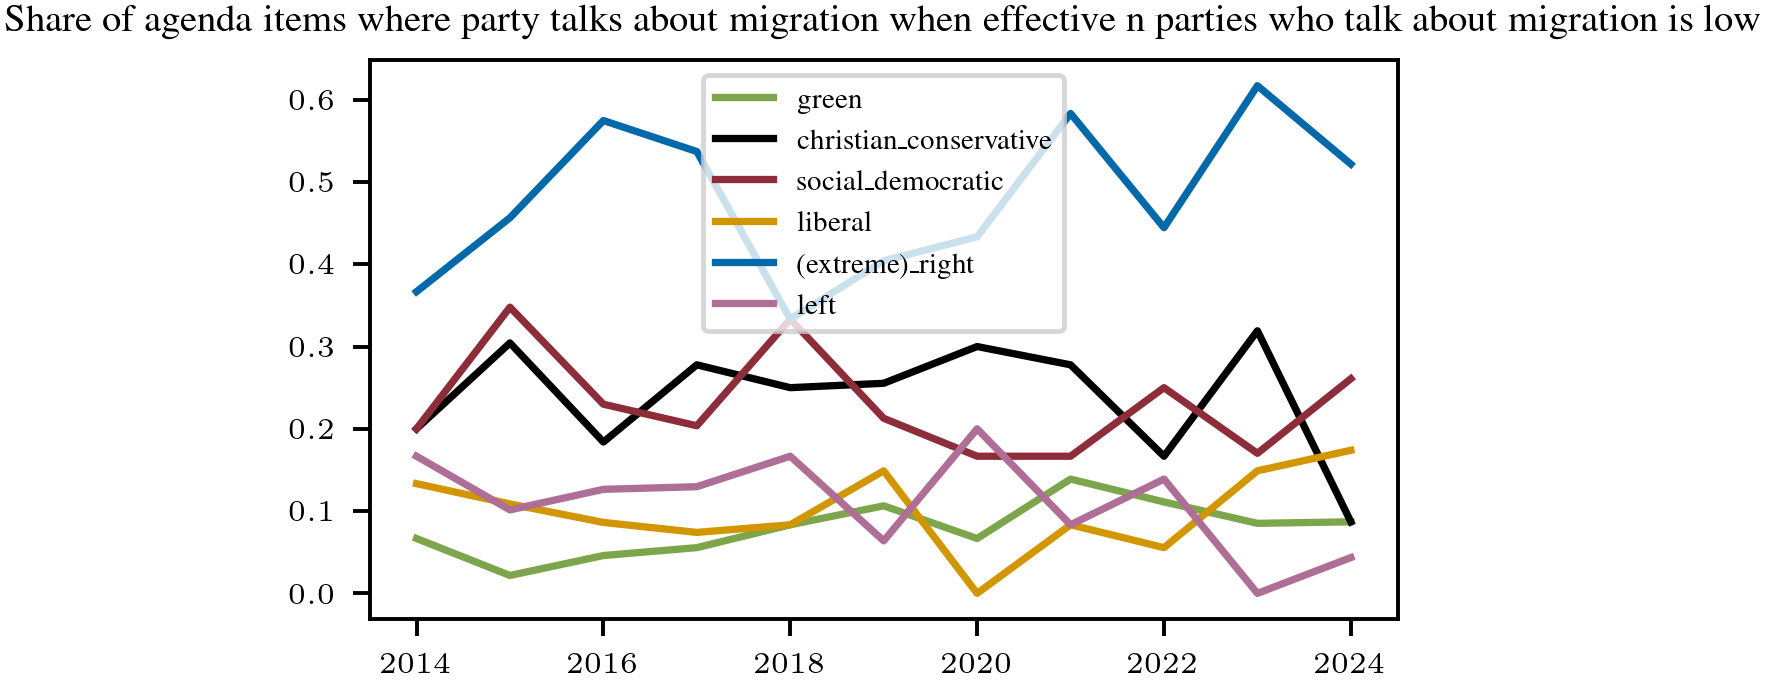

In [15]:
# plt.figure(figsize=(10, 7))
plt.title("Share of agenda items where party talks about migration when effective n parties who talk about migration is low")

years = []
n_per_party = {p: [] for p in df_final[party_column].unique()}

for year in df_final["year"].unique():
    years.append(year)

    n_agendas, counts_per_party, counts_per_team, _ = investigate_agenda_setting(year, 2)
    for party, proportion in counts_per_party.items():
        n_per_party[party].append(proportion)

    print(year, counts_per_team.most_common(1))
for party in n_per_party.keys(): 
    plt.plot(years, n_per_party[party], label=party, c=colormap[party])
plt.legend()

In [16]:
agenda_items_with_agenda_setting = (migration_agendas_with_debates[migration_agendas_with_debates["effective_n_parties_migration"] == 1]).index
df_agenda_setting_candidates = df_final[df_final["agenda"].isin(agenda_items_with_agenda_setting)]
print(len(agenda_items_with_agenda_setting),"agenda items with agenda setting")

501 agenda items with agenda setting


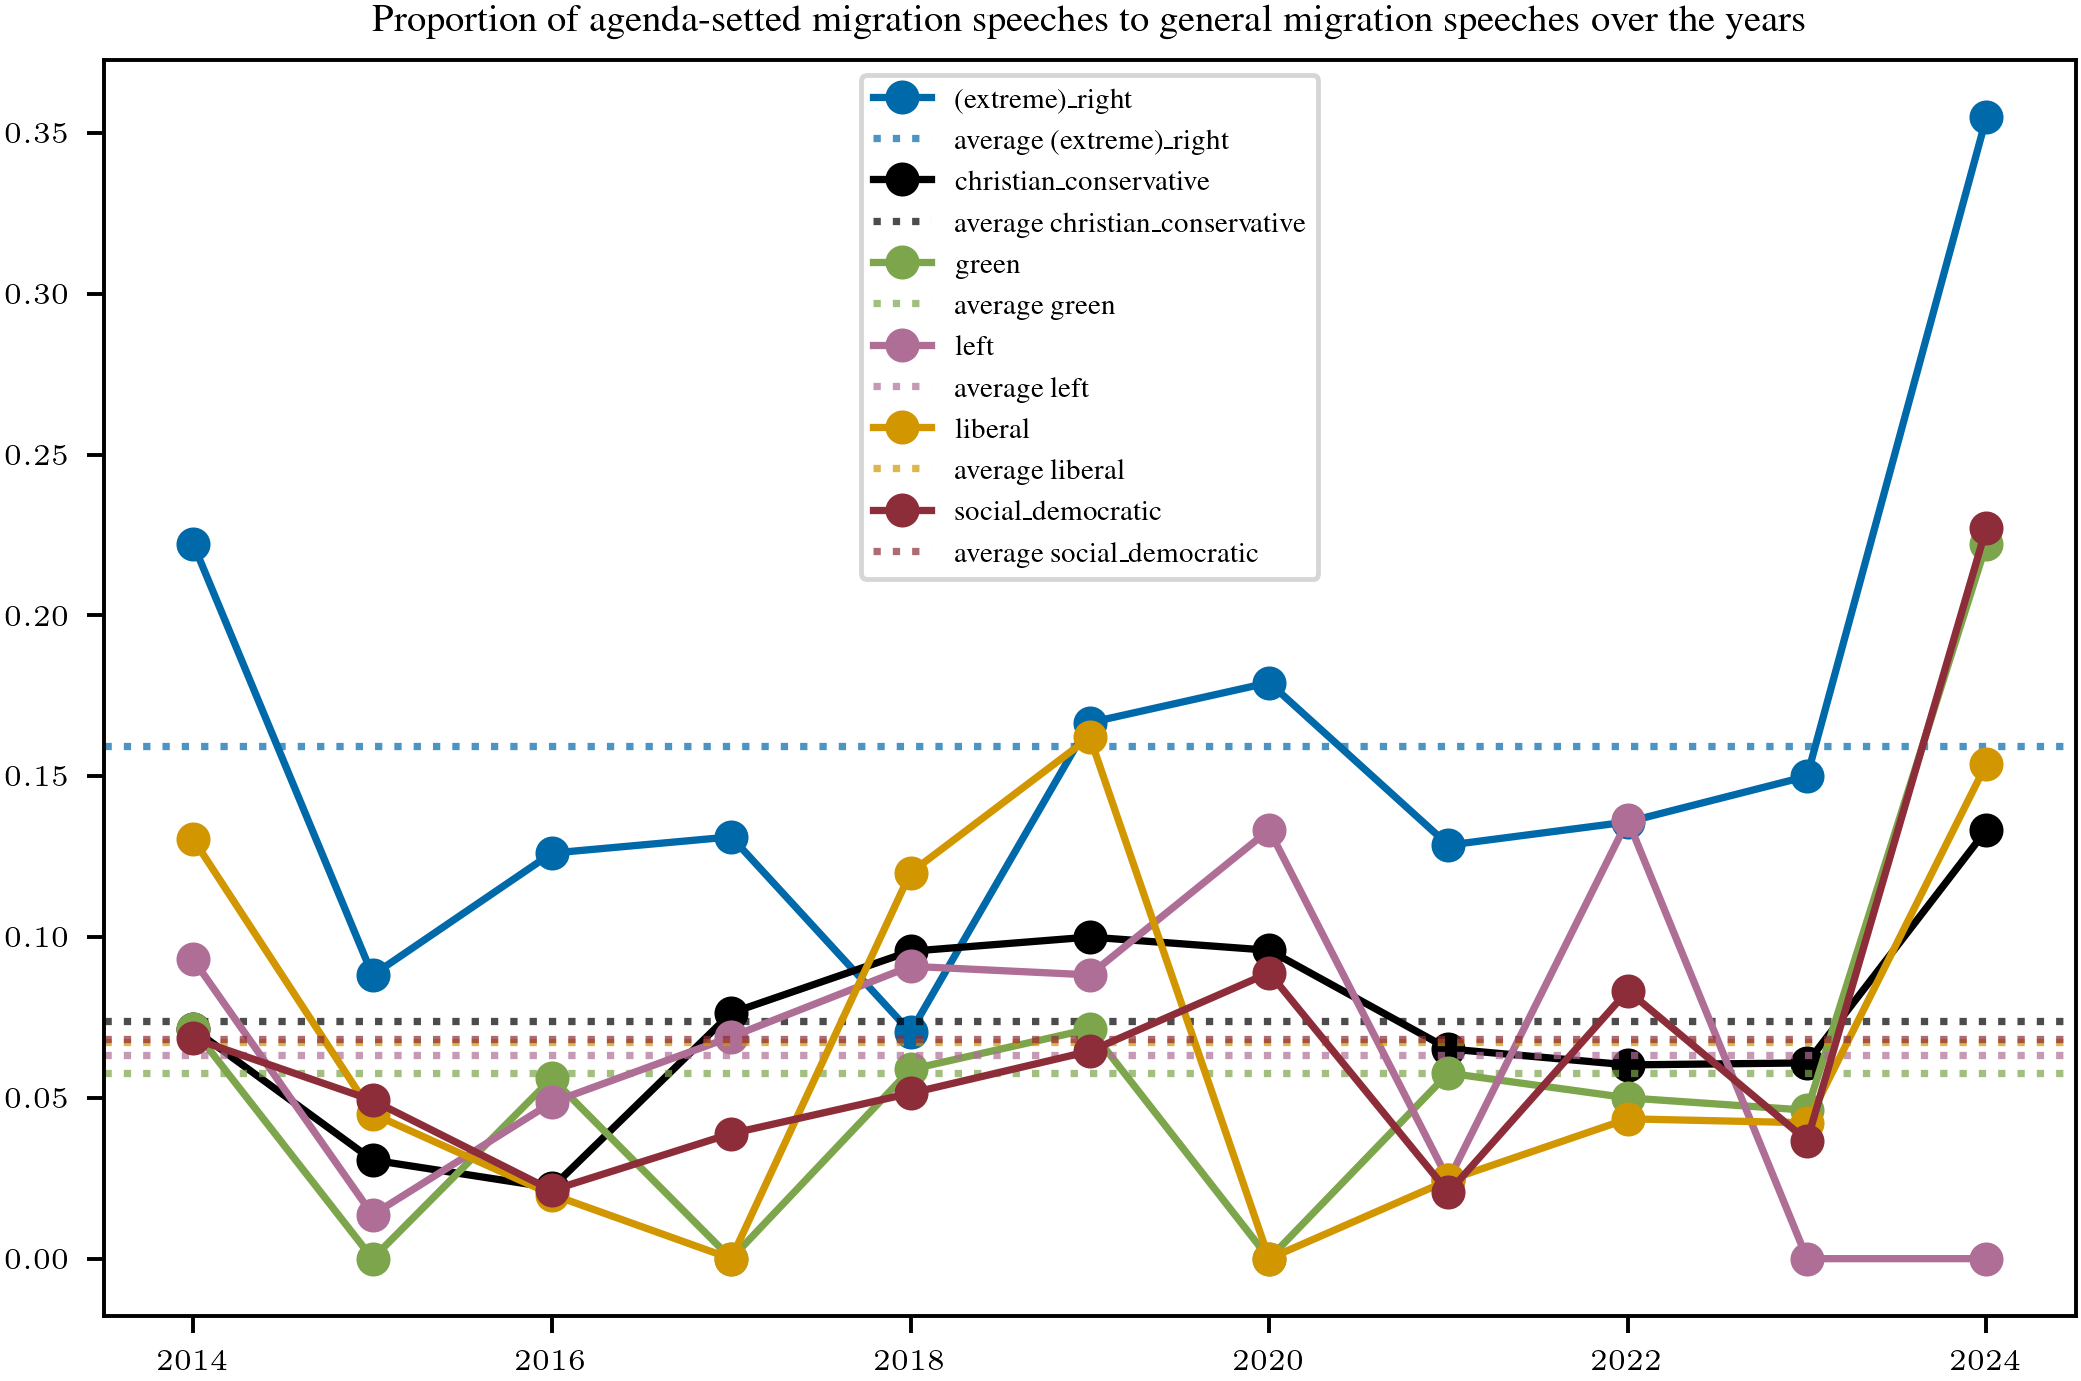

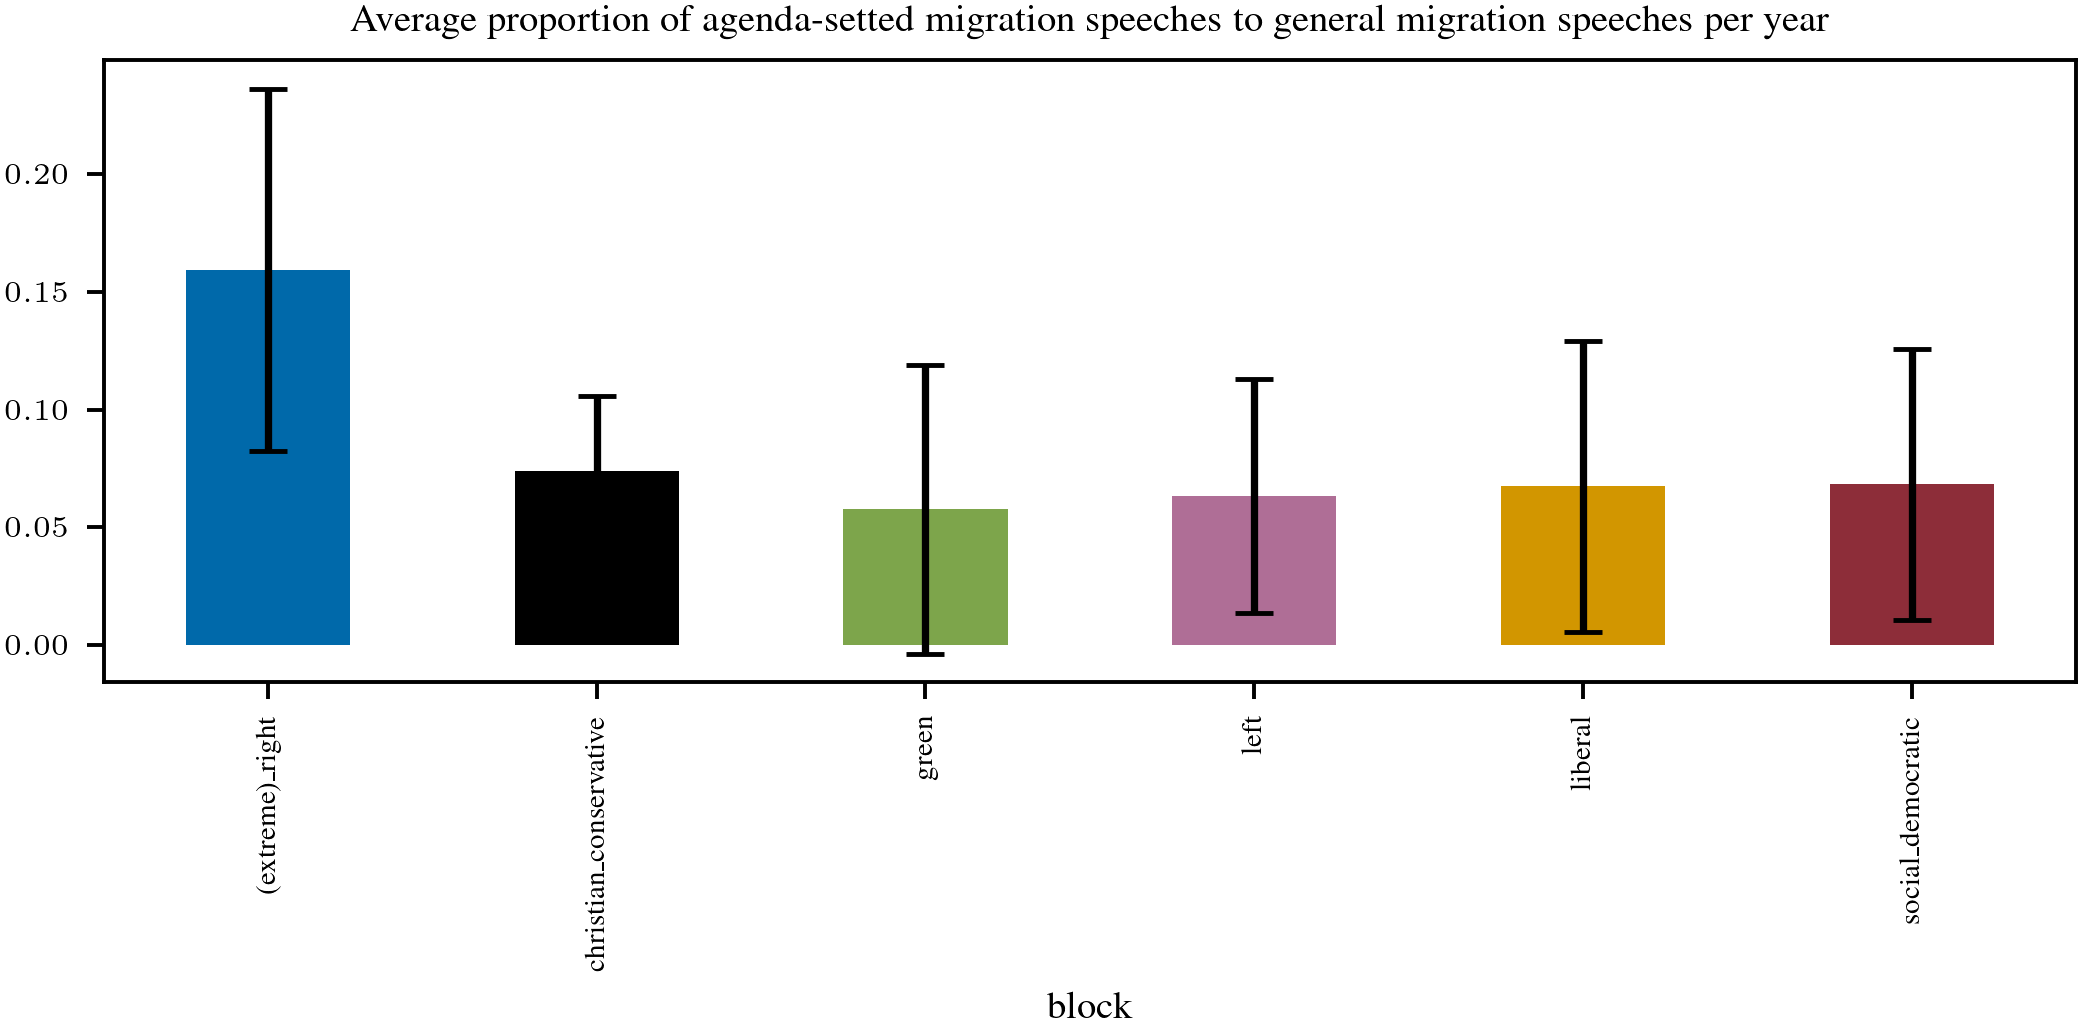

Explanation of plot: 
      This only considers agenda items with > 6 contributions (=> there needs to be some debate). 
      In these: for each party, what share of their migration speeches were agenda-setting speeches 
      (i.e. that party was the only one talking about migration)


In [17]:
def count_migration_speeches(df: pd.DataFrame): 
    return df[df[final_topic_col] > final_threshold].groupby(["block", "year"]).size().unstack(fill_value=0)

# per party: what is the number of speeches that the party is talking about migration, but is the only one (in the agenda items where there is a debate)
n_migration_speeches_per_party_agenda_setted = count_migration_speeches(df_agenda_setting_candidates)

# compare this to: 
# per party: what is the number of speeches that the party is talking about migration in total (in the agenda items where there is a debate)
n_migration_speeches_per_party_total = count_migration_speeches(df_final[df_final["agenda"].isin(migration_agendas_with_debates.index)])


proportion_agenda_set_speeches = n_migration_speeches_per_party_agenda_setted/n_migration_speeches_per_party_total

# we have data in wide format (block, year_1, ..., year_n)
# but we want to have (block, year, value)
proportion_per_block = proportion_agenda_set_speeches.reset_index().melt(id_vars="block", var_name="year", value_name="value").groupby("block")
avg_proportion_per_block = proportion_per_block["value"].mean()

plt.figure(figsize=(6, 4))
for party, values in proportion_per_block: 
    color = colormap[party]

    plt.plot(values["year"], values["value"], label=party, marker="o", c=color)
    plt.axhline(avg_proportion_per_block[party], c=color, alpha=0.7, linestyle=":", label="average "+party)

plt.title("Proportion of agenda-setted migration speeches to general migration speeches over the years")
plt.legend()
plt.show()

avg_proportion_per_block.plot(
    kind="bar", 
    figsize=(6, 3),
    color=avg_proportion_per_block.index.map(colormap), 
    yerr=proportion_per_block["value"].std(), 
    capsize=4,
    title="Average proportion of agenda-setted migration speeches to general migration speeches per year"
)
plt.show()
print("""Explanation of plot: 
      This only considers agenda items with > 6 contributions (=> there needs to be some debate). 
      In these: for each party, what share of their migration speeches were agenda-setting speeches 
      (i.e. that party was the only one talking about migration)"""
)


## When do partys do agenda-setting?

### Version 1: Analyzing agenda titles

First, clean the agenda titles (remove comments, and date)

In [18]:
# for each party, find one example of agenda setting: 
import re 

agenda_titles_with_agenda_setting = []
for party in df_final[party_column].unique(): 
    def clean_agenda_title(title): 
        # remove date from agenda item 
        title = title[:-10]
        # remove bracketed comments 
        title = re.sub(r'\(.*\)', '', title)
        # only keep letters and : or -
        title = re.sub(r'[^A-Za-z:\- ]+', '', title)
        title = title.strip()
        return title 

    agenda_items_that_party_did_agenda_setting = df_agenda_setting_candidates[(df_agenda_setting_candidates[final_topic_col] > final_threshold) & (df_agenda_setting_candidates[party_column] == party)]["agenda"].unique()

    for title in agenda_items_that_party_did_agenda_setting: 
        agenda_titles_with_agenda_setting.append({party_column: party, "cleaned": clean_agenda_title(title), "raw": title})

# now have dataframe with party, cleaned (cleaned agenda title), raw (full agenda title)
# => all titles of agenda items where that party agenda-set migration
agenda_titles_with_agenda_setting = pd.DataFrame(agenda_titles_with_agenda_setting)
agenda_titles_with_agenda_setting.drop_duplicates(subset=[party_column, "cleaned"], inplace=True)

Load embedding model to embedd agenda item titles

In [19]:
from transformers import AutoModel
from sentence_transformers import SentenceTransformer
import torch 

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu" 

model = SentenceTransformer(embedding_model, trust_remote_code=True).to(device)
def embedd_texts(model, texts, task="text-matching", batch_size=32):
    return model.encode(texts, task=task, batch_size=batch_size)

In [20]:
titles_embeddings = embedd_texts(model, agenda_titles_with_agenda_setting["cleaned"].tolist(), task="classification")
agenda_titles_with_agenda_setting["embedding"] = titles_embeddings.tolist()

In [21]:
" ".join(map(lambda x: ('%.3f' % x), titles_embeddings[0].tolist()))

'-0.090 0.038 0.007 0.069 0.060 0.020 -0.039 -0.021 0.116 0.019 0.028 -0.005 0.055 -0.002 0.049 0.089 0.053 0.016 -0.048 -0.041 0.019 0.026 0.013 0.032 0.037 0.015 0.011 0.012 -0.081 -0.006 -0.014 0.005 -0.012 -0.031 0.026 0.033 0.011 -0.052 0.021 -0.036 -0.036 0.023 0.025 -0.014 -0.012 -0.001 -0.057 -0.073 0.034 -0.012 0.020 0.033 -0.002 0.001 -0.071 -0.019 -0.001 0.002 0.004 -0.020 0.026 -0.016 0.014 0.004 0.078 0.006 -0.054 0.014 0.053 0.113 0.011 -0.019 -0.036 0.027 0.104 0.029 0.016 -0.001 0.017 -0.006 0.053 0.036 0.012 0.022 0.101 -0.073 0.039 -0.021 0.006 -0.043 0.006 -0.023 -0.012 0.021 0.038 0.011 0.000 -0.097 0.020 -0.035 0.047 -0.045 0.021 0.027 -0.033 0.021 0.042 -0.038 -0.021 -0.078 0.017 -0.044 0.009 -0.063 -0.017 0.011 0.001 0.019 0.005 0.013 0.064 -0.051 0.023 -0.032 0.027 0.006 -0.026 0.048 -0.019 -0.062 -0.019 0.021 0.007 -0.016 0.002 0.022 -0.006 -0.009 0.033 -0.050 -0.032 -0.034 -0.025 -0.009 0.046 0.042 0.010 -0.033 0.067 -0.070 0.022 -0.024 -0.039 -0.047 0.047 0.0

Fit linear regression model to see if there is a meaningful pattern within the agenda item titles 
=> Question: do parties talk about migration in party-specific contexts?

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

regression_model = LogisticRegression()

X = np.stack(agenda_titles_with_agenda_setting["embedding"])
y = np.array(agenda_titles_with_agenda_setting[party_column])
regression_model.fit(X, y) 

# make sure the model is not learning the embeddings by heart => evaluation not on raw X, but on StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(regression_model, X, y, cv=cv, scoring="accuracy")

print("Cross validation accuracy:", scores.mean())
print("Cross validation std:", scores.std())

Cross validation accuracy: 0.4201902748414376
Cross validation std: 0.03511121285463504


=> there is a pattern in the data (party is predictable from agenda title embedding)
=> what agenda item titles are most characteristic for each party? in other words, for each party, based on the agenda item title, where do we know with most certainty that the party will agenda-set, rather than a different party?

In [23]:
scores = regression_model.predict_proba(X)
print_top_k = 15
agenda_title_column = "cleaned" # "raw"
most_decisive_titles = {}
print("Most decicive agenda titles:")
for i, party in enumerate(regression_model.classes_):
    top_idx = np.argsort(-scores[:, i])[:print_top_k]

    # NOTE: this includes also false-positives, the acutal agenda setting party might be another,
    # this is just where the model is surest that it is the current party
    print(f"\n{party}")
    for k in top_idx: 
        print(agenda_titles_with_agenda_setting.iloc[k][agenda_title_column]) #, "|", party == agenda_titles_with_agenda_setting.iloc[k][party_column])
    # print("\n".join(agenda_titles_with_agenda_setting.iloc[top_idx][agenda_title_column]))
    print("="*100)
    # keep full agenda to investigate further
    most_decisive_this_party = agenda_titles_with_agenda_setting.iloc[top_idx]
    most_decisive_this_party = most_decisive_this_party[most_decisive_this_party[party_column] == party].reset_index()
    most_decisive_titles[party] = most_decisive_this_party["raw"]


Most decicive agenda titles:

(extreme)_right
EU-Timor-Leste agreement on the short-stay visa waiver
EU-Samoa agreement on the short-stay visa waiver
EU-Vanuatu agreement on the short-stay visa waiver
EU-Dominica agreement on the short-stay visa waiver
EU-United Arab Emirates agreement on the short-stay visa waiver
EU Agency for Law Enforcement Training
EU-Tonga Agreement on the short-stay visa waiver
Women domestic workers and carers in the EU
EU-Palau Agreement on the short-stay visa waiver
EU-Solomon Islands Agreement on the short-stay visa waiver
EU-Saint Vincent and the Grenadines agreement on the short-stay visa waiver
EU-Trinidad and Tobago agreement on the short-stay visa waiver
EU-Marshall Islands Agreement on the short-stay visa waiver
EU-Saint Lucia agreement on the short-stay visa waiver
Discharge : European Fisheries Control Agency

christian_conservative
progress report on Serbia
progress report on Serbia
Progress report on Serbia
Commissions approval of Germanys revised 

In [24]:
for party, most_decisive_this_party in most_decisive_titles.items(): 
    print(party)
    # print(most_decisive_this_party)
    print_agendas(most_decisive_this_party, 3)   
    print("\n"*5)

(extreme)_right
5.7. EU-Timor-Leste agreement on the short-stay visa waiver (A8-0327/2015 - Mariya Gabriel)2015-12-15
Parties talking about migration: (extreme)_right (2)
[ ] 1: Marina Albiol Guzmán (NGL/The Left - left) [0% migration]
	This agreement allows Timorese and European citizens to travel through both territories without the need for a visa. Despite disagreeing with the way in which the negotiations have been carried out - with obscurantism and without the participation of parliaments -, I have voted in favor of its ratification since we are fine with anything that represents a lightening of bureaucratic burden and the end of restrictions on freedom of movement.
[ ] 2: Louis Aliot (ENF/ID - (extreme)_right) [14% migration]
	I voted against the agreement with East Timor on the visa waiver for short stays. If in this report the liberalization of visas for short-term stays is presented as an opportunity to boost tourism, simplify travel conditions for entrepreneurs or even encou

### Version 2: Analyzing 'true' debate topics

In [25]:
from src.constants import TOPIC_LABELS, N_TOPICS, ORDER_BLOCK

In [26]:
topic_columns = [f"topic_{i}" for i in range(N_TOPICS)]

topic_scores_per_agenda = df_final[["agenda"] + topic_columns].groupby("agenda").mean()
top_topic_per_agenda = topic_scores_per_agenda.idxmax(axis=1).map(lambda topic_name: int(topic_name.split("_")[-1])).rename("top_topic_idx")

agenda_titles_with_agenda_setting = agenda_titles_with_agenda_setting.join(top_topic_per_agenda, "raw")

In [27]:
all_agenda_items = pd.DataFrame(top_topic_per_agenda)
all_agenda_items = all_agenda_items.join(agenda_titles_with_agenda_setting.set_index("raw")["block"])
agenda_set_party_one_hot = pd.get_dummies(all_agenda_items['block'])
all_agenda_items = all_agenda_items.join(agenda_set_party_one_hot)
all_agenda_items["n_agenda_set"] = ~(all_agenda_items['block'].isna())
all_agenda_items.drop("block", inplace=True, axis=1)

n_agenda_set_per_topic = all_agenda_items.groupby("top_topic_idx").sum()
n_agenda_set_per_topic["topic_name"] = TOPIC_LABELS

# blocks = df_final["block"].unique()
blocks = ORDER_BLOCK

First, in absolute numbers: what topics are most "disturbed" by agenda setting? 

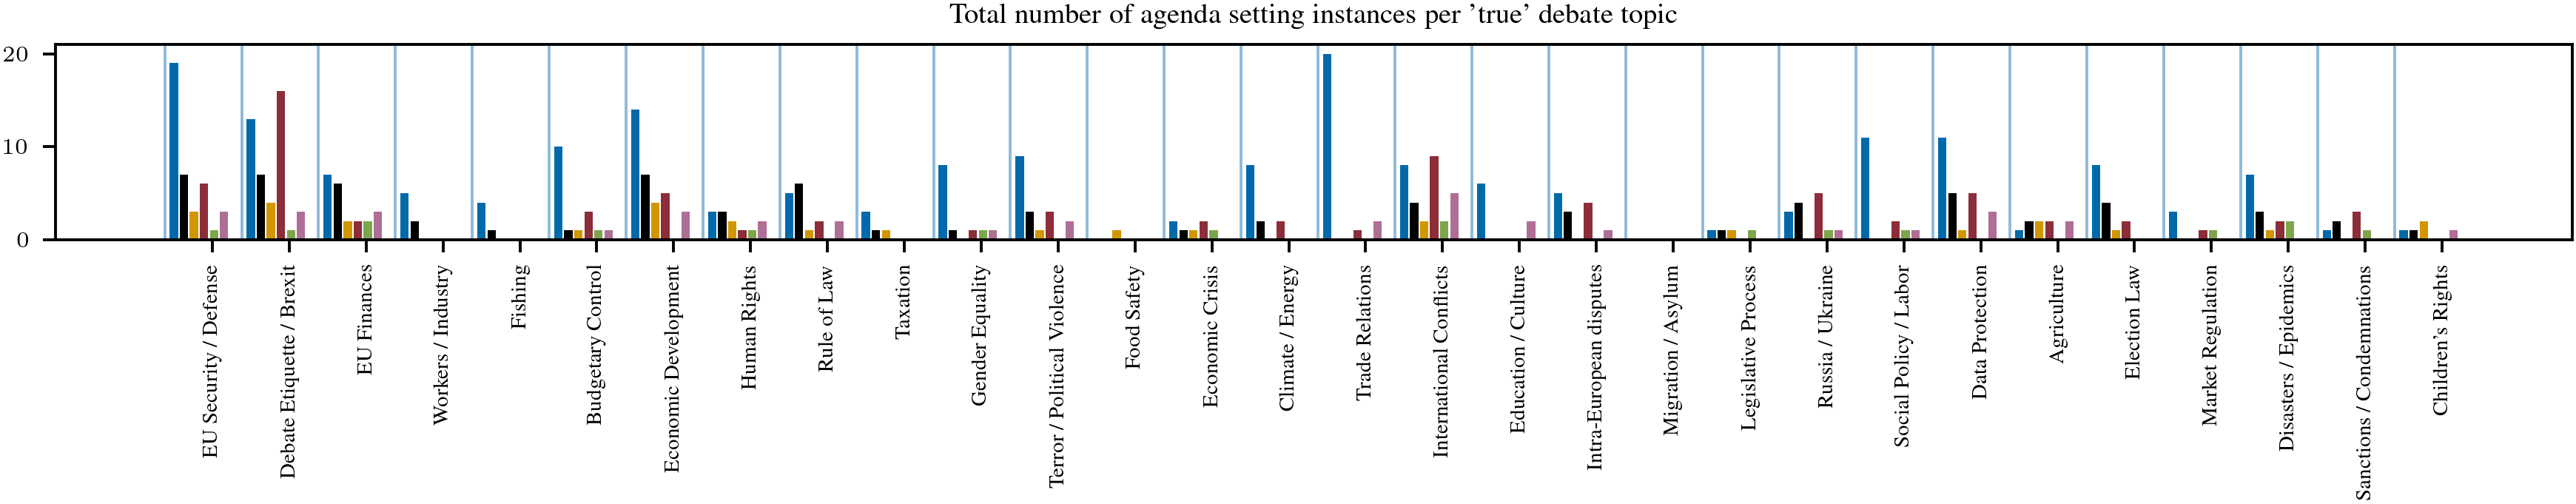

In [28]:
bar_width = 1.2
padding_width = 1
group_width = bar_width * len(blocks) + 1 + padding_width
X = np.arange(N_TOPICS) * group_width

plt.figure(figsize=(10, 2))
for i, block in enumerate(blocks): 
    plt.bar(X+i*bar_width, n_agenda_set_per_topic[block], label=block, color=colormap[block], width=bar_width-0.2)

    ax = plt.gca()

for x in X:
    ax.axvline(x - bar_width/2 - padding_width/2, linewidth=0.8, alpha=0.5, zorder=0)

plt.title("Total number of agenda setting instances per 'true' debate topic")
plt.xticks(X + group_width / 2, TOPIC_LABELS, rotation=90)
# plt.legend()
None

=> especially when others talk about trade relations, EU security, Econimic Development, and many others, the extreme right seems to hijack the debate and talk about migration instead

But what about the other parties that perform less agenda setting? When do they do it? 

For each block: what is their most frequent agenda setting topic?

In [29]:
for block in blocks: 
    most_frequent_agenda_setting_topic = agenda_titles_with_agenda_setting[agenda_titles_with_agenda_setting["block"] == block]["top_topic_idx"].value_counts(normalize=True).sort_values(ascending=False)
    top3topics = most_frequent_agenda_setting_topic.head(3)
    print(block, " ".join([f"'{TOPIC_LABELS[i]}' ({'%.3f' % top3topics[i]});" for i in top3topics.index]))

(extreme)_right 'Trade Relations' (0.102); 'EU Security / Defense' (0.097); 'Economic Development' (0.071);
christian_conservative 'EU Security / Defense' (0.091); 'Debate Etiquette / Brexit' (0.091); 'Economic Development' (0.091);
liberal 'Debate Etiquette / Brexit' (0.129); 'Economic Development' (0.129); 'EU Security / Defense' (0.097);
social_democratic 'Debate Etiquette / Brexit' (0.203); 'International Conflicts' (0.114); 'EU Security / Defense' (0.076);
green 'EU Finances' (0.118); 'Disasters / Epidemics' (0.118); 'International Conflicts' (0.118);
left 'International Conflicts' (0.132); 'EU Finances' (0.079); 'Debate Etiquette / Brexit' (0.079);


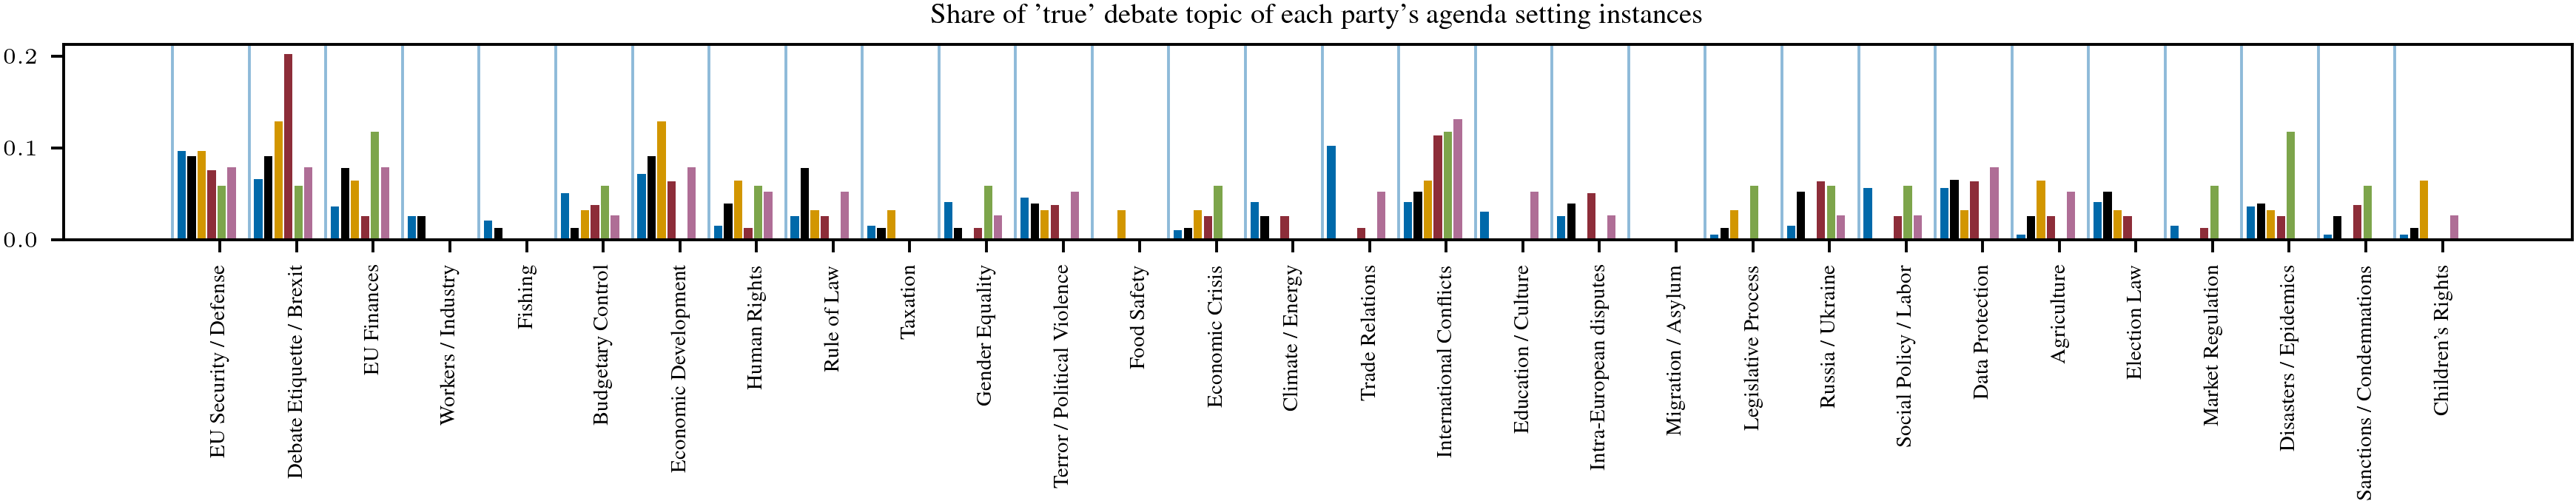

In [30]:
bar_width = 1.2
padding_width = 1
group_width = bar_width * len(blocks) + 1 + padding_width
X = np.arange(N_TOPICS) * group_width

plt.figure(figsize=(10, 2))
for i, block in enumerate(blocks): 
    # agendas_with_agenda_setting[agendas_with_agenda_setting["block"] == block]["top_topic_idx"]
    value_counts_topics = np.zeros(N_TOPICS)
    value_counts_topics_ = agenda_titles_with_agenda_setting[agenda_titles_with_agenda_setting["block"] == block]["top_topic_idx"].value_counts(normalize=True)
    value_counts_topics[value_counts_topics_.index] = value_counts_topics_.values

    plt.bar(X+i*bar_width, value_counts_topics, label=block, color=colormap[block], width=bar_width-0.2)

    ax = plt.gca()

for x in X:
    ax.axvline(x - bar_width/2 - padding_width/2, linewidth=0.8, alpha=0.5, zorder=0)

plt.title("Share of 'true' debate topic of each party's agenda setting instances")
plt.xticks(X + group_width / 2, TOPIC_LABELS, rotation=90)
# plt.legend()
None

(extreme)_right: 'Trade Relations', 'EU Security / Defense' 

christian_conservative + liberal: 'EU Security / Defense', 'Debate Etiquette / Brexit', 'Economic Development'

social_democratic + left + green: 'EU Finances' (0.118); 'Disasters / Epidemics', 'International Conflicts' (0.118); 'Debate Etiquette / Brexit' (0.203);

=> right wings bring up migration when talking about international relations 
=> parties from the other side of the spectrum bring it up rather in humanitarian conflict situations

In [31]:
agenda_titles_with_agenda_setting

,block,cleaned,raw,embedding,top_topic_idx
0,green,EU-Egypt strategic and comprehensive partnersh...,17. EU-Egypt strategic and comprehensive partn...,"[-0.08966886252164841, 0.038365382701158524, 0...",7
1,green,The repressive environment in Afghanistan incl...,20.2. The repressive environment in Afghanista...,"[-0.07564389705657959, 0.041888222098350525, -...",28
2,green,Order of business,11. Order of business2023-11-08,"[-0.1641739457845688, 0.01752566732466221, -0....",20
3,green,This is Europe - Debate with the President of ...,5. This is Europe - Debate with the President ...,"[-0.09769182652235031, 0.027106011286377907, -...",21
4,green,One-minute speeches on matters of political im...,14. One-minute speeches on matters of politica...,"[-0.12078642845153809, -0.03974511846899986, 0...",1
...,...,...,...,...,...
496,left,The EUs role in the Middle East peace process,9.8. The EU's role in the Middle East peace pr...,"[-0.1408393383026123, 0.05019714683294296, -0....",16
497,left,Mass graves of the missing persons of Ashia at...,3.3. Mass graves of the missing persons of Ash...,"[-0.11479275673627853, 0.07265225797891617, -0...",11
498,left,Mobilisation of the Contingency Margin in,11.3. Mobilisation of the Contingency Margin i...,"[-0.11114276945590973, -0.0020295027643442154,...",2
499,left,Shortage of funding for the World Food Program...,15. Shortage of funding for the World Food Pro...,"[-0.14110806584358215, 0.0930313840508461, 0.0...",16


In [32]:
example_agendas = [
    ('(extreme)_right', 'EU Security / Defense'), 
    # ('christian_conservative', 'EU Security / Defense'),
    # ('liberal', 'Economic Development'), 
    # ('social_democratic', 'Debate Etiquette / Brexit'),  
    # ('green', 'Disasters / Epidemics'),  
    ('left', 'International Conflicts'),  
]

for block, topic in example_agendas: 
    topic_idx = TOPIC_LABELS.index(topic)
    example = agenda_titles_with_agenda_setting[(agenda_titles_with_agenda_setting["block"] == block) & (agenda_titles_with_agenda_setting["top_topic_idx"] == topic_idx)].head(4)
    print_agendas(example["raw"])


4. Strengthening European Defence in a volatile geopolitical landscape - Implementation of the common foreign and security policy – annual report 2023 - Implementation of the common security and defence policy – annual report 2023 (joint debate - European security and defence)2024-02-28
Parties talking about migration: (extreme)_right (1)
[ ] 4: Manfred Weber (PPE - christian_conservative) [0% migration]
	Madam President, President von der Leyen, Council, dear colleagues, as EPP, we are, first of all, happy to have the debate today. Such an upgraded top-level debate about the Defence Union. EPP was asking for this for a long period of time and that’s why it is good to have it. For us, first of all, I want to underline that the subject itself is not innovative at all. I said it already in my last speech: in 1945, Adenauer, Schuman, De Gasperi started with the Defence Union. The French Parliament rejected, De Gasperi had tears in his eyes after it failed in the French Parliament. The ide

In [33]:
from src.constants import MIGRATION_TOPIC_ID
all_agenda_items[all_agenda_items["top_topic_idx"] == MIGRATION_TOPIC_ID]

,top_topic_idx,(extreme)_right,christian_conservative,green,left,liberal,social_democratic,n_agenda_set
agenda,,,,,,,,
1. Opening of the sitting2018-10-03,19,False,False,False,False,False,False,False
10. Building of a wall on the Polish – Belarus border in the Białowieża primeval forest (debate)2022-05-05,19,False,False,False,False,False,False,False
10. EU policies and actions to protect children in the context of migration (debate)2016-10-26,19,False,False,False,False,False,False,False
10. Implementation report on the EU Trust Funds and the Facility for Refugees in Turkey (continuation of debate)2021-10-05,19,False,False,False,False,False,False,False
10. Legal migration policy and law (debate)2021-11-23,19,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
9. The deterioration of the situation of refugees as a consequence of the Russian aggression against Ukraine (debate)2022-03-08,19,False,False,False,False,False,False,False
9. The need for an immediate and humanitarian EU response to the current situation in the refugee camp in Moria (debate)2020-09-17,19,False,False,False,False,False,False,False
9.10. Provisional measures in the area of international protection for the benefit of Italy and Greece (A8-0245/2015 - Ska Keller)2015-09-09,19,False,False,False,False,False,False,False
